In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/eth_courses/Autumn22/nlp/spanningtrees/

/content/drive/MyDrive/eth_courses/Autumn22/nlp/spanningtrees


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
!apt install -y graphviz
!pip install graphviz torch torchtext transformers datasets conllu 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 365 kB 57.6 MB/s 
     |████████████████████████████████| 6.6 MB 45.9 MB/s 
     |████████████████████████████████| 596 kB 60.2 MB/s 
     |████████████████████████████████| 101 kB 9.4 MB/s 
     |████████████████████████████████| 115 kB 53.8 MB/s 
     |████████████████████████████████| 141 kB 63.1 MB/s 
     |████████████████████████████████| 212 kB 61.3 MB/s 
     |████████████████████████████████| 127 kB 60.2 MB/s 
  Attempting uninstall: urllib3
   

In [3]:
from benji_transformer_play import *

scorer = Scorer2().to(device)
scorer.load_state_dict(torch.load('runs/colab_07_21-14_26_16/save_epoch29.pt', map_location=device))

data = datasets.load_dataset("universal_dependencies", "en_gum")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
val_data = [sequence for sequence in data['test'] if len(sequence['tokens']) < 20]
model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True).to(device)

<All keys matched successfully>

  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
input_data = val_data[:4]
sentences_embedding, sentences_word_embeddings, targets = get_embeddings(input_data, tokenizer, model)
i = 0
word_embeddings, sentence_embedding, target = sentences_word_embeddings[i], sentences_embedding[i], targets[i]



loss, pred, constr, mst_prob, mst_neg_log_prob, target_prob, target_neg_log_probs = train_on_sentence(word_embeddings, sentence_embedding, target, scorer)

input_data[i]['tokens']
constr
input_data[i]['head']

target_np = target.detach().cpu().numpy()
np.all(target_np == constr[1:])

['The',
 'prevalence',
 'of',
 'discrimination',
 'across',
 'racial',
 'groups',
 'in',
 'contemporary',
 'America',
 ':']

array([-1,  2,  0,  4,  2,  7,  7,  4, 10, 10,  4,  2])

['2', '0', '4', '2', '7', '7', '2', '10', '10', '2', '2']

False

['The', 'prevalence', 'of', 'discrimination', 'across', 'racial', 'groups', 'in', 'contemporary', 'America', ':']


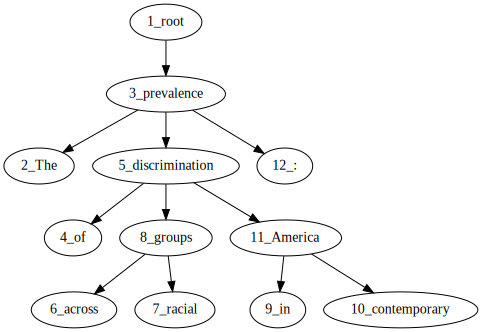

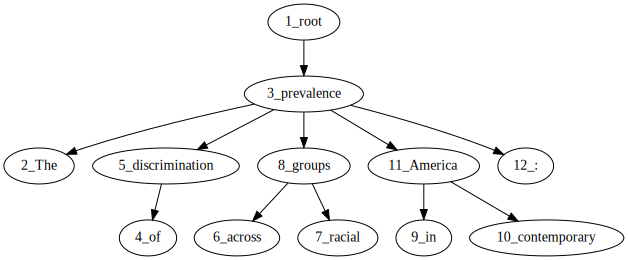

In [9]:
import graphviz

def get_graphviz(tokens, dep_to_head):
  G = graphviz.Digraph()
  tokens = ['root'] + tokens
  # print(tokens)
  for i, token in enumerate(tokens):
    G.node('q' + str(i), str(i+1) + '_' + token)

  for dep_i, head_i in enumerate(dep_to_head):
    h, d = tokens[head_i], tokens[dep_i + 1]
    # print(h, d)
    G.edge('q' + str(head_i), 'q' + str(dep_i + 1))
  return G

G1 = get_graphviz(input_data[0]['tokens'], constr[1:])
print(input_data[0]['tokens'])
G2 = get_graphviz(input_data[0]['tokens'], list(target.detach().numpy()))
G1
G2

In [10]:
big_mat = scorer(torch.concat([sentence_embedding, word_embeddings]), tanh=False)

mat = big_mat[1:, 1:]  # nxn word head x dep scores
r = big_mat[0, 1:]  # n root -> word scores


torch.Size([12, 11])

9
0


<BarContainer object of 50 artists>

<BarContainer object of 1 artists>

Text(0.5, 0, '50 beams search sorted by score')

Text(0, 0.5, 'dep tree edge factored score sum')

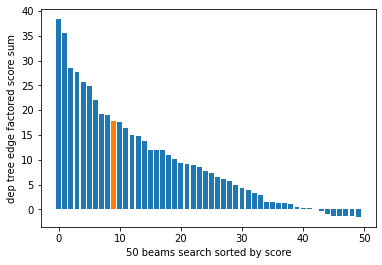

In [13]:
extended_mat = torch.concat([r.unsqueeze(dim=0), mat], dim=0)
extended_mat.shape

extended_mat_np = extended_mat.detach().cpu().numpy()

bs_out = beam_search_matrix(extended_mat_np, n_beam=50)

parses = [triple[1] for triple in bs_out]

correct = [np.all(parse == target_np) for parse in parses]
correct_i = np.where(correct)[0]
correct_i = correct_i[0] if len(correct_i) != 0 else None

mst_correct = [np.all(parse == constr[1:]) for parse in parses]
mst_correct_i = np.where(mst_correct)[0]
mst_correct_i = mst_correct_i[0] if len(mst_correct_i) != 0 else None

print(correct_i)
print(mst_correct_i)

import matplotlib.pyplot as plt
plt.bar(list(range(len(parses))), [triple[2] for triple in bs_out])
plt.bar(correct_i, bs_out[correct_i][2])
plt.xlabel('50 beams search sorted by score')
plt.ylabel('dep tree edge factored score sum')

# G_beam_searches = [get_graphviz(input_data[0]['tokens'], list(parse)) for parse in parses]
# for G, triple in zip(G_beam_searches, bs_out):
#   G
#   print(f"score: {triple[2]}")
# G_beam_searches[0]
# bs_out[0][2]
# G_beam_searches[1]
# bs_out[1][2]
# G_beam_searches[2]
# bs_out[2][2]

In [100]:
i[0]

9

In [47]:
input_data = val_data[:20]
sentences_embedding, sentences_word_embeddings, targets = get_embeddings(input_data, tokenizer, model)
i = 16
word_embeddings, sentence_embedding, target = sentences_word_embeddings[i], sentences_embedding[i], targets[i]



loss, pred, constr, mst_prob, mst_neg_log_prob, target_prob, target_neg_log_probs = train_on_sentence(word_embeddings, sentence_embedding, target, scorer)

input_data[i]['tokens']
constr
input_data[i]['head']

target_np = target.detach().cpu().numpy()
np.all(target_np == constr[1:])

['sexual', 'orientation', ';']

array([-1,  0,  1,  2])

['2', '0', '2']

False

['sexual', 'orientation', ';']


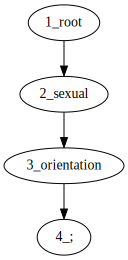

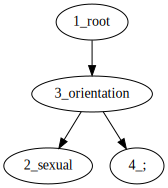

In [48]:
import graphviz

def get_graphviz(tokens, dep_to_head):
  G = graphviz.Digraph()
  tokens = ['root'] + tokens
  # print(tokens)
  for i, token in enumerate(tokens):
    G.node('q' + str(i), str(i+1) + '_' + token)

  for dep_i, head_i in enumerate(dep_to_head):
    h, d = tokens[head_i], tokens[dep_i + 1]
    # print(h, d)
    G.edge('q' + str(head_i), 'q' + str(dep_i + 1))
  return G

G1 = get_graphviz(input_data[i]['tokens'], constr[1:])
print(input_data[i]['tokens'])
G2 = get_graphviz(input_data[i]['tokens'], list(target.detach().numpy()))
G1
G2

In [49]:
big_mat = scorer(torch.concat([sentence_embedding, word_embeddings]), tanh=False)

mat = big_mat[1:, 1:]  # nxn word head x dep scores
r = big_mat[0, 1:]  # n root -> word scores


torch.Size([4, 3])

3
0


<BarContainer object of 8 artists>

<BarContainer object of 1 artists>

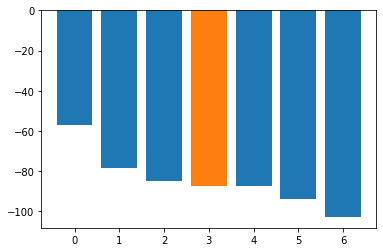

In [50]:
extended_mat = torch.concat([r.unsqueeze(dim=0), mat], dim=0)
extended_mat.shape

extended_mat_np = extended_mat.detach().cpu().numpy()

bs_out = beam_search_matrix(extended_mat_np, n_beam=8)

parses = [triple[1] for triple in bs_out]

correct = [np.all(parse == target_np) for parse in parses]
correct_i = np.where(correct)[0]
correct_i = correct_i[0] if len(correct_i) != 0 else None

mst_correct = [np.all(parse == constr[1:]) for parse in parses]
mst_correct_i = np.where(mst_correct)[0]
mst_correct_i = mst_correct_i[0] if len(mst_correct_i) != 0 else None

print(correct_i)
print(mst_correct_i)

import matplotlib.pyplot as plt
plt.bar(list(range(len(parses))), [triple[2] for triple in bs_out])
if correct_i:
  plt.bar(correct_i, bs_out[correct_i][2])



G_beam_searches = [get_graphviz(input_data[i]['tokens'], list(parse)) for parse in parses]
# for G, triple in zip(G_beam_searches, bs_out):
#   G
#   print(f"score: {triple[2]}")
# G_beam_searches[0]
# bs_out[0][2]
# G_beam_searches[1]
# bs_out[1][2]
# G_beam_searches[2]
# bs_out[2][2]

In [37]:
extended_mat_np

array([[-16.44078 , -21.964602, -45.959885],
       [-35.478233, -13.045111, -48.93541 ],
       [-37.505028, -43.668182, -27.780647],
       [-35.079395, -22.018314, -47.382366]], dtype=float32)

In [40]:
target_np

array([2, 0, 2])

In [41]:
constr[1:]

array([0, 1, 2])

In [45]:
parses

[array([0, 1, 1], dtype=int16),
 array([3, 0, 2], dtype=int16),
 array([2, 0, 2], dtype=int16),
 array([0, 3, 1], dtype=int16),
 array([3, 1, 0], dtype=int16),
 array([3, 3, 0], dtype=int16),
 array([0, 1, 0], dtype=int16),
 array([0, 1, 2], dtype=int16)]

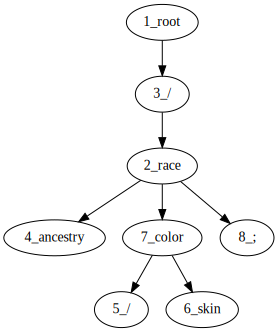

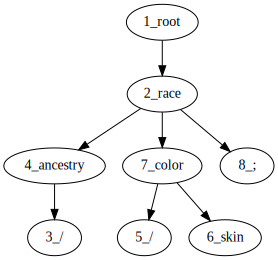

In [19]:
G_beam_searches[0]
G_beam_searches[1]

In [244]:
input_data[i]['tokens']

['race', '/', 'ancestry', '/', 'skin', 'color', ';']

In [51]:
import tqdm
stats = []
for j in tqdm.tqdm(range(50)):
  input_data = val_data[j:j+2]
  sentences_embedding, sentences_word_embeddings, targets = get_embeddings(input_data, tokenizer, model)
  i = 0
  word_embeddings, sentence_embedding, target = sentences_word_embeddings[i], sentences_embedding[i], targets[i]

  loss, pred, constr, mst_prob, mst_neg_log_prob, target_prob, target_neg_log_probs = train_on_sentence(word_embeddings, sentence_embedding, target, scorer)

  target_np = target.detach().cpu().numpy()
  mst_matches = np.all(target_np == constr[1:])

  big_mat = scorer(torch.concat([sentence_embedding, word_embeddings]), tanh=False)

  mat = big_mat[1:, 1:]  # nxn word head x dep scores
  r = big_mat[0, 1:]  # n root -> word scores

  extended_mat = torch.concat([r.unsqueeze(dim=0), mat], dim=0)
  extended_mat_np = extended_mat.detach().cpu().numpy()

  bs_out = beam_search_matrix(extended_mat_np, n_beam=10)

  parses = [triple[1] for triple in bs_out]

  correct = [np.all(parse == target_np) for parse in parses]
  correct_i = np.where(correct)[0]
  correct_i = correct_i[0] if len(correct_i) != 0 else None

  mst_correct = [np.all(parse == constr[1:]) for parse in parses]
  mst_correct_i = np.where(mst_correct)[0]
  mst_correct_i = mst_correct_i[0] if len(mst_correct_i) != 0 else None

  stats.append((mst_matches, correct_i, mst_correct_i))



100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


In [52]:
stats2 = [(a, b if b is not None else -1, c if c is not None else -1) for a, b, c in stats]
stats2[:5]

[(False, 9, 0), (True, -1, -1), (True, 0, 0), (True, 0, 0), (True, 0, 0)]

(array([15., 23.,  4.,  1.,  1.,  2.,  1.,  1.,  1.,  1.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 <a list of 10 Patch objects>)

<BarContainer object of 1 artists>

Text(0.5, 0, 'beam number of ground truth dep tree out of 10 beams')

Text(0, 0.5, 'frequency')

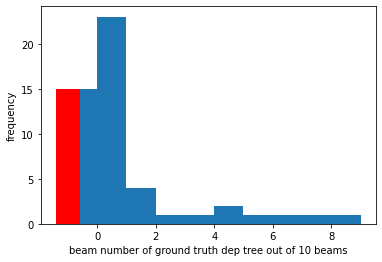

In [22]:
plt.hist([x[1] for x in stats2])
plt.bar(-1, len([x[1] for x in stats2 if x[1] == -1]), color="red")
plt.xlabel("beam number of ground truth dep tree out of 10 beams")
plt.ylabel("frequency")

In [53]:
weird = [i for i, x in enumerate(stats2) if x[2] not in [0, -1]]
weird

[]